# import libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

In [2]:
# configure API key

quandl.ApiConfig.api_key = 'qHzCe1rHau6JnUf-We_k'

In [3]:
# Importing the IMF Cross Country Macroeconomic Statistics - US GDP

data = quandl.get('ODA/USA_NGDPRPPPPC')

## note: 
I'm looking at US GDP only for this analysis. As I've learned over previous steps in this project, spending power is a leading variable in assessing personal happiness, so for this exercise I will be focusing on US GDP. While it is not per capita, it still offers a window into one country's spending power upon which further analysis can be done in the context of the larger project. 

In [4]:
# assessing imported data

data.head(5)

,Value
Date,
1980-12-31,29135.98
1981-12-31,29577.30
1982-12-31,28767.38
1983-12-31,29813.85
1984-12-31,31692.73


In [5]:
data.shape

(45, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

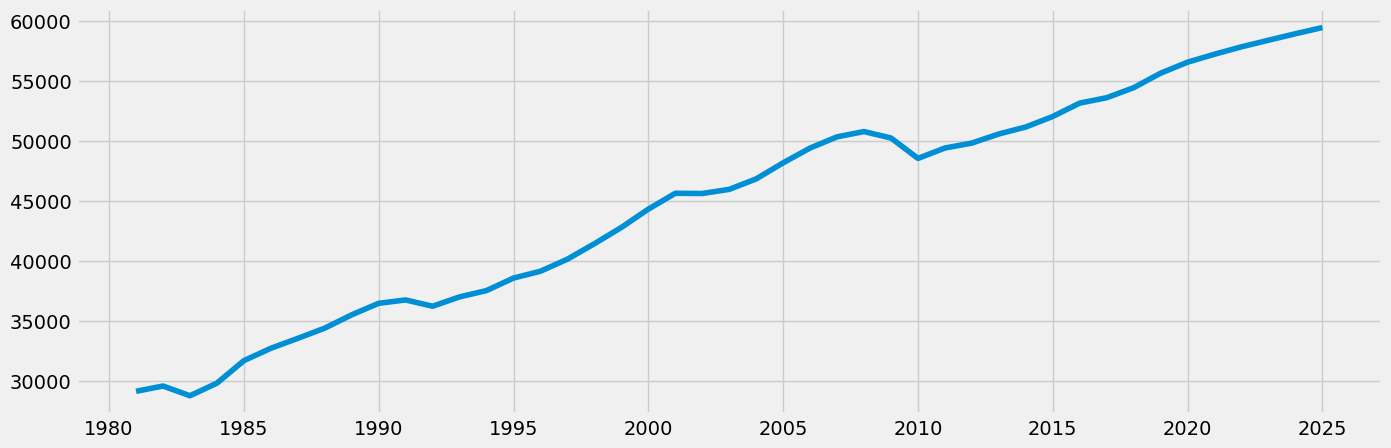

In [7]:
# plotting the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

# subsetting, wrangling, and cleaning time-series data

In [8]:
# resetting index to use the "Date" column as a filter

data_2 = data.reset_index()

In [9]:
data_2.head(5)

,Date,Value
0,1980-12-31,29135.98
1,1981-12-31,29577.30
2,1982-12-31,28767.38
3,1983-12-31,29813.85
4,1984-12-31,31692.73


In [10]:
# subsetting to remove forecasted data

data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2022-12-01')]

In [11]:
data_sub.shape

(42, 2)

In [12]:
data_sub.head(5)

,Date,Value
0,1980-12-31,29135.98
1,1981-12-31,29577.30
2,1982-12-31,28767.38
3,1983-12-31,29813.85
4,1984-12-31,31692.73


In [13]:
# setting the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
1980-12-31,29135.98
1981-12-31,29577.30
1982-12-31,28767.38
1983-12-31,29813.85
1984-12-31,31692.73


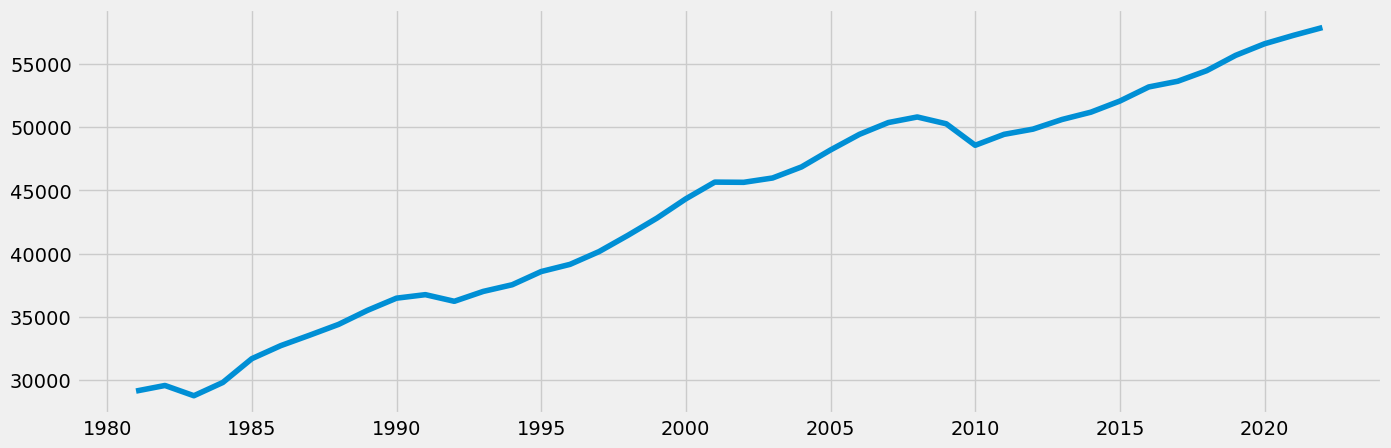

In [14]:
# plotting the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [15]:
# checking for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [16]:
# checking for duplicates

dups = data_sub.duplicated()
dups.sum()

0

# decomposition

In [17]:
# decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [18]:
# defining a fixed size for spacial charts

from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

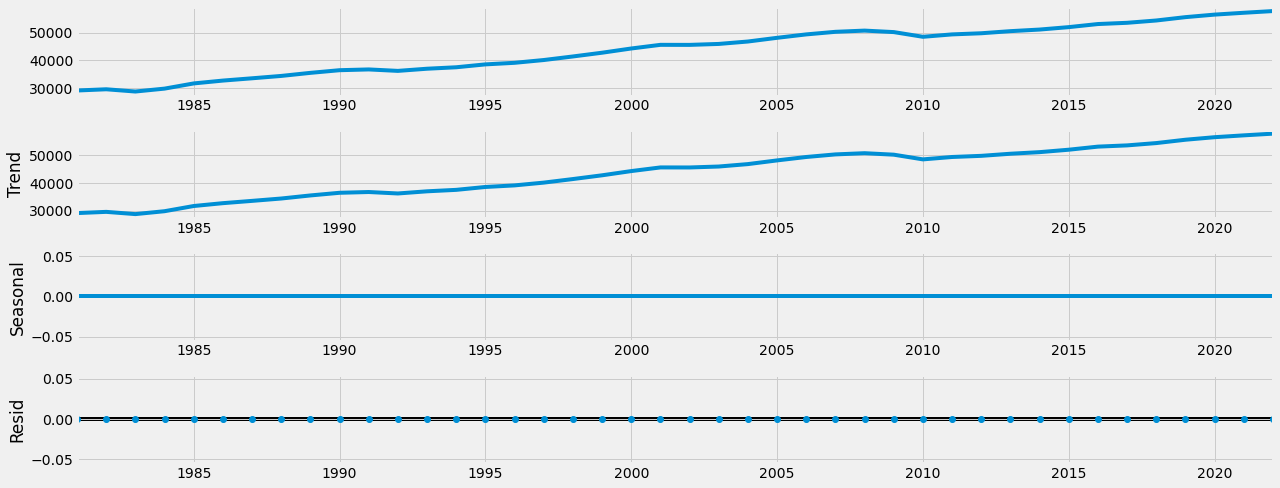

In [19]:
# plotting the components

decomposition.plot()
plt.show()

## discussing results of the chart above: 

The first line, the level, shows the data itself for comparison. 

The second shows the trend of the data. This data has very little noise, so the trend is nearly the same as the level. This trend shows that GDP has risen continuously, with some small blips that can be explained by world events, such as the 2008 financial crisis and recession from 1980-2022. 

The third line shows seasonality, and since it is flat there is NO seasonality to this data. 

The final line represents noise in the data, of which there is very little. 

# testing for stationarity with the dickey-fuller test

In [20]:
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.640767
p-value                         0.861502
Number of Lags Used             1.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


## discussing results of the test above: 

The test statistic is larger than the critical values, meaning we can't reject the null hypothesis.

The p-value is more than .05, so the test result is not significant. 

This means that there is a unit root in the data, and the data is non-stationary.

# stationizing the data

In [21]:
data_diff = data_sub - data_sub.shift(1)

In [22]:
data_diff.dropna(inplace = True)

In [23]:
data_diff.head()

,Value
datetime,
1981-12-31,441.32
1982-12-31,-809.92
1983-12-31,1046.47
1984-12-31,1878.88
1985-12-31,1029.28


In [24]:
data_diff.columns

Index(['Value'], dtype='object')

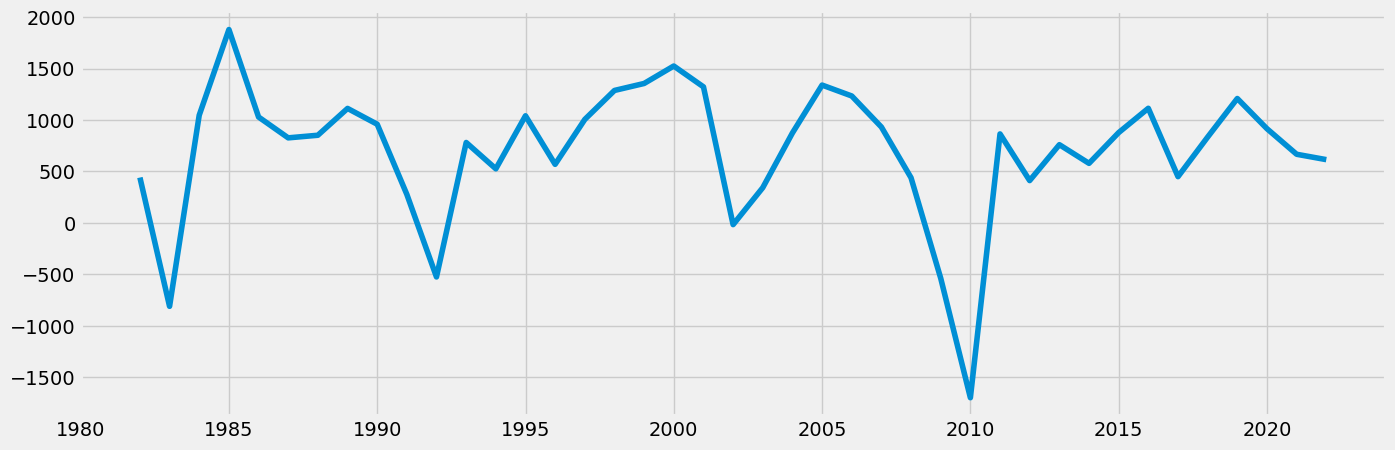

In [26]:
# assessing what the differencing did to the time series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [27]:
# repeating dickey-fuller test

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.367211
p-value                         0.000339
Number of Lags Used             0.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


## discussing results of the second test: 

The test statistic is smaller than the critical values, meaning we CAN reject the null hypothesis.

The p-value is less than .05, so the test result IS significant. 

This means that the data is now stationary. 

# checking autocorrelations

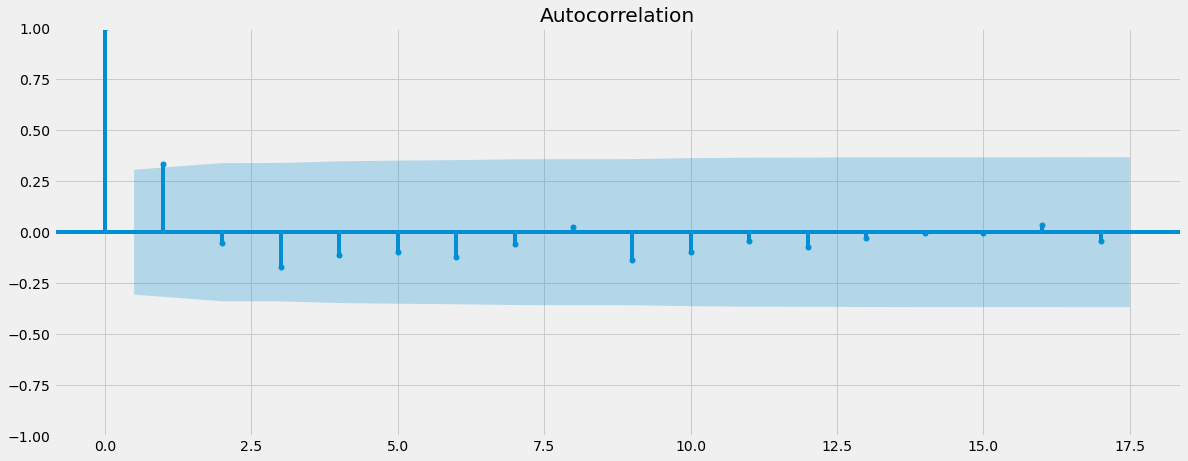

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(data_diff)
plt.show()

# conclusion

As GDP continues to rise, it will be interesting to explore whether happiness also rises, stagnates, or even falls in relation to the other variables. 